In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import Logit
import patsy

from scipy import stats

import pymc3 as pm

## Process the raw training data

In [2]:
with pd.HDFStore("out/Training_2002_2005.h5") as store:
    print store
    df = store["first_author"]

<class 'pandas.io.pytables.HDFStore'>
File path: out/Training_2002_2005.h5
/first_author            frame        (shape->[41618369,56])


In [3]:
df.head()

,source_id,source_year,source_j,source_n_mesh,source_n_mesh_ex,source_is_eng,source_country,source_is_journal,source_is_review,source_is_case_rep,...,eth1,eth2,pos,pos_nice,sink_last_ncites,sink_prev_ncites,auth_last_npapers,auth_prev_papers,jj_sim,is_self_cite
0,16526454,2005,J AOAC Int,11,53,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,1,1,2,1,1,20,14.6053,0
1,16526454,2005,J AOAC Int,11,53,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,1,1,1,2,1,20,14.6053,1
2,14595765,2003,J Comp Neurol,17,71,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,1,1,5,8,1,7,0.0000,0
3,14595765,2003,J Comp Neurol,17,71,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,1,1,5,17,1,7,5.5691,0
4,14595765,2003,J Comp Neurol,17,71,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,1,1,9,22,1,7,5.5691,0


In [4]:
df.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

In [5]:
df["eth_weight"] = 0.5 # Partial weight to multi ethnicity
df.ix[df.eth2 == "UNKNOWN", "eth_weight"] = 1 # Full weight to single ethnicity

## Top 15 countries in PUBMED using MapAffil

```
SELECT mapaffil_author, COUNT(PMID) as C FROM Country GROUP BY mapaffil_author ORDER BY C DESC LIMIT 50;
```


```
USA	5630449
-	5381526
UK	1258220
JAPAN	1093784
GERMANY	943164
FRANCE	683470
ITALY	596575
CANADA	535345
CHINA	445054
AUSTRALIA	338799
SPAIN	332491
NETHERLANDS	315492
SWEDEN	277981
INDIA	255261
SWITZERLAND	206675
```

In [6]:
df.ix[df.source_country == "-", "source_country"] = "UNKNOWN" # Set - to unknown

In [7]:
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]

In [8]:
df.source_country = df.source_country.astype("category", categories=TOP_15_COUNTRIES, ordered=False).fillna("OTHER")

In [9]:
df.source_country.cat.categories

Index([u'USA', u'UNKNOWN', u'UK', u'JAPAN', u'GERMANY', u'FRANCE', u'ITALY',
       u'CANADA', u'CHINA', u'AUSTRALIA', u'SPAIN', u'NETHERLANDS', u'SWEDEN',
       u'INDIA', u'OTHER'],
      dtype='object')

## Top ethnicities

Multiple ethnicities are given partial weight

Code
```
df_author = pd.read_csv("data/AuthorEthGender.txt", sep="\t")
df_author["eth_weight"] = df_author.Ethnea.str.split("-").apply(lambda x: 1. / len(x))
df_author[["eth1", "eth2"]] = df_author.Ethnea.str.split("-", expand=True)
t = pd.concat([df_author.groupby("eth1")["eth_weight"].sum(),
               df_author.groupby("eth2")["eth_weight"].sum()],
             axis=1).sum(axis=1)
t.sort_values(ascending=False)
```

```
ENGLISH       2782108.5
GERMAN         906626.0
HISPANIC       824886.5
CHINESE        733996.5
JAPANESE       729496.0
SLAV           600884.5
FRENCH         549123.5
ITALIAN        425322.0
INDIAN         312127.5
NORDIC         304026.0
ARAB           253439.5
DUTCH          213680.0
KOREAN         138553.5
ISRAELI        126600.5
TURKISH         84244.0
GREEK           74970.0
AFRICAN         68456.5
UNKNOWN         49239.0
HUNGARIAN       44897.0
THAI            32824.0
ROMANIAN        24788.0
BALTIC           8647.5
VIETNAMESE       5267.0
INDONESIAN       3043.5
CARIBBEAN        2002.5
TOOSHORT          626.0
MONGOLIAN         188.5
POLYNESIAN         85.0
ERROR              33.0
```

In [11]:
df.ix[df.eth1.isin(
        ["UNKNOWN", "TOOSHORT", "ERROR"]),
      "eth1"] = "UNKNOWN" # Set unknown ethnicities
df.ix[df.eth2.isin(
        ["UNKNOWN", "TOOSHORT", "ERROR"]),
      "eth2"] = "UNKNOWN" # Set unknown ethnicities

In [12]:
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]

In [13]:
df.eth1 = df.eth1.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna("OTHER")
df.eth2 = df.eth2.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna("OTHER")

## Gender

In [14]:
GENDERS = ["-", "F", "M"]

In [15]:
df.gender = df.gender.astype("category", categories=GENDERS, ordered=False).fillna("-")

## Change dtype of comparisons to boolean
Make sure `is_self_cite` is not set to bool. Change its values in the resulting files as well.

In [16]:
df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']] = df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']].astype("bool")

In [17]:
df.dtypes

source_id                  int64
source_year                int64
source_j                  object
source_n_mesh              int64
source_n_mesh_ex           int64
source_is_eng               bool
source_country          category
source_is_journal           bool
source_is_review            bool
source_is_case_rep          bool
source_is_let_ed_com        bool
source_T_novelty         float64
source_V_novelty         float64
source_PT_novelty        float64
source_PV_novelty        float64
source_ncites              int64
source_n_authors           int64
sink_id                    int64
sink_year                  int64
sink_j                    object
sink_n_mesh                int64
sink_n_mesh_ex             int64
sink_is_eng                 bool
sink_is_journal             bool
sink_is_review              bool
sink_is_case_rep            bool
sink_is_let_ed_com          bool
sink_T_novelty           float64
sink_V_novelty           float64
sink_PT_novelty          float64
sink_PV_no

## Store model data

In [18]:
df = df.drop(["source_j", "sink_j", "auid"], axis=1)
with pd.HDFStore('out/ModelData.20160529.h5') as cstore:
    cstore.append(
        'first_author',
        df,
        format='table',
        data_columns=['source_country','gender', 'eth1', 'eth2'])

## Load data from HDF5

In [17]:
with pd.HDFStore('out/ModelData.20160529.h5') as cstore:
    df = cstore['first_author']

## Model data generation

In [19]:
import model_functions as mf

MF reloaded2


In [20]:
GENDERS = ["-", "F", "M"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]

sns.set_context("poster")
sns.set_style("ticks")

In [21]:
def logit(p):
    return np.log(p/(1-p))


def get_empirical_logit(df, X_col, y_col, conditioning_var="Gender",
    bins=None, testing=False):
    if testing:
        # If testing the just print X and y columns
        print X_col, y_col
        return conditioning_var, ({"llf": 0.1}, "TEMP SUMMARY")
    ## Not testing. Fit the models and return the measures
    print X_col, conditioning_var, y_col
    t = df.pivot_table(index=pd.cut(df[X_col], bins=bins),
      columns=conditioning_var, values=y_col,
      aggfunc=[np.mean, len])
    t = t.set_index(bins[1:])
    return t


auth_prev_papers
auth_prev_papers gender is_self_cite
sink_prev_ncites
sink_prev_ncites gender is_self_cite
source_n_mesh_ex
source_n_mesh_ex gender is_self_cite
sink_n_mesh_ex
sink_n_mesh_ex gender is_self_cite
jj_sim
jj_sim gender is_self_cite
year_span
year_span gender is_self_cite
source_ncites
source_ncites gender is_self_cite
source_n_authors
source_n_authors gender is_self_cite


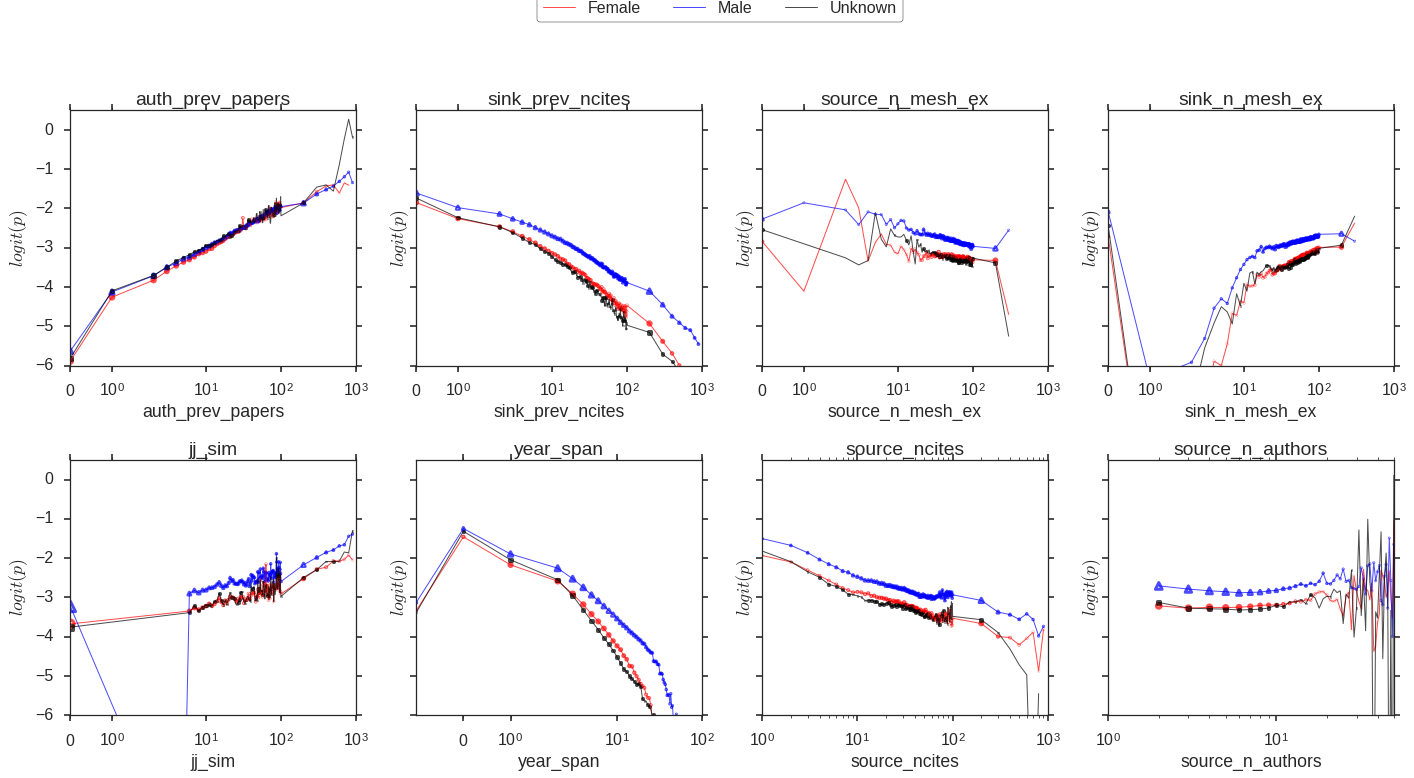

In [26]:
colors = ["r", "b", "k"]
markers = ["o", "^", "s"]
conditioning_names = ["F", "M", "-"]
cm = plt.cm.get_cmap('Greys')
plt.clf()
plt.close("all")
fig, ax = plt.subplots(2,4, sharey=True, figsize=(20,10))
ax = ax.flatten()
plot_id = 0
y_feature_col = "is_self_cite"
xcols = ["auth_prev_papers", "sink_prev_ncites", 
         "source_n_mesh_ex", "sink_n_mesh_ex", "jj_sim",
         "year_span", "source_ncites", "source_n_authors"]
for k in xcols:
    if k in ["auth_prev_papers", "sink_prev_ncites", "source_n_mesh_ex", "sink_n_mesh_ex", "jj_sim"]:
        bins = np.array([-0.1] + range(100) + range(100,1000,100))
        xscale = "symlog"
        xlims = [0, 1000]
    if k in ["source_ncites"]:
        bins = np.array(range(-1,100) + range(100,1000,100))
        xscale = "log"
        xlims = [1, 1000]
    if k in ["source_n_authors"]:
        bins = np.array(range(-1,100) + range(100,1000,100))
        xscale = "log"
        xlims = [1, 50]
    if k in ["year_span"]:
        bins = np.array([-10, -1] + range(100))
        xscale = "symlog"
        xlims = [-1, 100]
    print k
    t = get_empirical_logit(df, k, y_feature_col,
    conditioning_var="gender",
    bins=bins,
    testing=False)
    t_logit = logit(t["mean"]).clip(-10,10)
    lgd_items = []
    for j,c in enumerate(conditioning_names):
        scp = ax[plot_id].scatter(t_logit.index, t_logit[c], edgecolor=colors[j], s=t["len"][c] / 1e5, 
                                  facecolor='none', alpha=0.7, linewidth=3, marker=markers[j])
        line, = ax[plot_id].plot(t_logit[t_logit[c].notnull()].index, t_logit[t_logit[c].notnull()][c],
                                 marker="None", linestyle="-", color=colors[j], label=c, lw=1, alpha=0.7)
        lgd_items.append(line)
    ax[plot_id].set_xlabel(k)
    ax[plot_id].set_ylabel("$logit(p)$")
    ax[plot_id].set_title(k)
    ax[plot_id].set_xscale(xscale)
    ax[plot_id].set_xlim(xlims)
    ax[plot_id].set_ylim((-6,0.5))
    plot_id += 1
plt.margins(0.1)
#ax.legend(handles=lgd_items, loc="upper center", ncol=3)
lgd = fig.legend(lgd_items, ["Female", "Male", "Unknown"],
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,1.1), ncol=3,
                 frameon=True, fancybox=True, prop={"size": 16})
fig.tight_layout()
plt.savefig("Empirical_1.pdf")

source_T_novelty
source_T_novelty gender is_self_cite
source_V_novelty
source_V_novelty gender is_self_cite
source_PT_novelty
source_PT_novelty gender is_self_cite
source_PV_novelty
source_PV_novelty gender is_self_cite
sink_T_novelty
sink_T_novelty gender is_self_cite
sink_V_novelty
sink_V_novelty gender is_self_cite
sink_PT_novelty
sink_PT_novelty gender is_self_cite
sink_PV_novelty
sink_PV_novelty gender is_self_cite


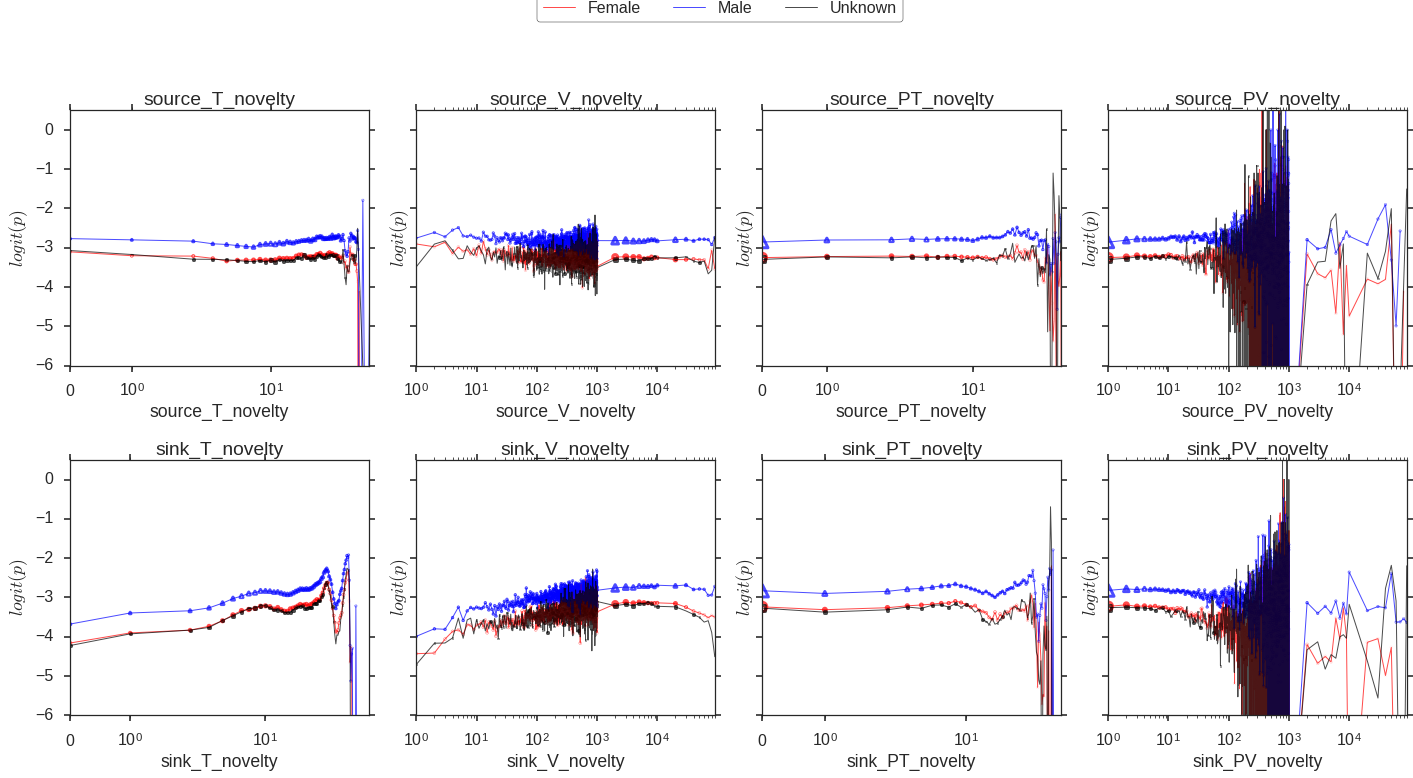

In [27]:
colors = ["r", "b", "k"]
markers = ["o", "^", "s"]
conditioning_names = ["F", "M", "-"]
cm = plt.cm.get_cmap('Greys')
plt.clf()
plt.close("all")
fig, ax = plt.subplots(2,4, sharey=True, figsize=(20,10))
ax = ax.flatten()
plot_id = 0
y_feature_col = "is_self_cite"
xcols = ["source_T_novelty", "source_V_novelty", 
         "source_PT_novelty", "source_PV_novelty",
         "sink_T_novelty", "sink_V_novelty", 
         "sink_PT_novelty", "sink_PV_novelty",]
for k in xcols:
    if k in ["source_T_novelty", "source_PT_novelty", "sink_T_novelty", "sink_PT_novelty"]:
        bins = np.array([-1] + range(0,100) + range(100,1000,100))
        xscale = "symlog"
        #xlims = [0, 1000]
    if k in ["source_V_novelty", "source_PV_novelty", "sink_V_novelty", "sink_PV_novelty"]:
        bins = np.array(range(0,1000) + range(1000,10000,1000) + range(10000,100000, 10000))
        xscale = "log"
        #xlims = [1, 1000]
    print k
    t = get_empirical_logit(df, k, y_feature_col,
    conditioning_var="gender",
    bins=bins,
    testing=False)
    t_logit = logit(t["mean"]).clip(-10,10)
    lgd_items = []
    for j,c in enumerate(conditioning_names):
        scp = ax[plot_id].scatter(t_logit.index, t_logit[c], edgecolor=colors[j], s=t["len"][c] / 1e5, 
                                  facecolor='none', alpha=0.7, linewidth=3, marker=markers[j])
        line, = ax[plot_id].plot(t_logit[t_logit[c].notnull()].index, t_logit[t_logit[c].notnull()][c],
                                 marker="None", linestyle="-", color=colors[j], label=c, lw=1, alpha=0.7)
        lgd_items.append(line)
    xlims = [t_logit[t_logit[c].notnull()].index.min(),
             t_logit[t_logit[c].notnull()].index.max()]
    ax[plot_id].set_xlabel(k)
    ax[plot_id].set_ylabel("$logit(p)$")
    ax[plot_id].set_title(k)
    ax[plot_id].set_xscale(xscale)
    ax[plot_id].set_xlim(xlims)
    ax[plot_id].set_ylim((-6,0.5))
    plot_id += 1

#ax.legend(handles=lgd_items, loc="upper center", ncol=3)
lgd = fig.legend(lgd_items, ["Female", "Male", "Unknown"],
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,1.1), ncol=3,
                 frameon=True, fancybox=True, prop={"size": 16})
fig.tight_layout()
plt.savefig("Empirical_2.pdf")

In [80]:
formula = ("is_self_cite ~ I(auth_prev_papers == 0) + np.log10(auth_prev_papers + 1)"
           "+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ I(source_ncites == 1) + np.log10(source_ncites) + I(np.log10(source_ncites)**2)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )
y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")

Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w


In [81]:
X.columns

Index([u'Intercept', u'I(auth_prev_papers == 0)[T.True]',
       u'C(gender, levels=GENDERS)[T.F]', u'C(gender, levels=GENDERS)[T.M]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.UK]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]',
       u'C(source_country, level

In [82]:
y.columns

Index([u'is_self_cite'], dtype='object')

In [83]:
model = Logit(y,X)
res = model.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.153254
         Iterations 10


LinAlgError: Singular matrix

In [ ]:
print "X correlation"

In [ ]:
X_corr = X.corr()

In [ ]:
X_corr.shape

## Testing multi valued ethnicity function

In [41]:
df.eth1.value_counts()

ENGLISH     11118099
GERMAN       4513420
CHINESE      3819668
JAPANESE     3318697
HISPANIC     3066985
FRENCH       2986317
ITALIAN      2286478
OTHER        2240601
INDIAN       1674516
NORDIC       1644960
SLAV         1603630
DUTCH        1282595
ARAB         1114727
KOREAN        858926
UNKNOWN        88750
Name: eth1, dtype: int64

In [43]:
df.eth2.value_counts()

UNKNOWN     37148718
ENGLISH      1163693
GERMAN        656867
FRENCH        573340
OTHER         377593
HISPANIC      357320
NORDIC        234813
CHINESE       212907
ITALIAN       190306
DUTCH         187093
SLAV          169539
ARAB          116624
INDIAN        112140
KOREAN         72392
JAPANESE       45024
Name: eth2, dtype: int64

In [42]:
df.eth_weight.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: eth_weight, dtype: float64

In [46]:
for i in range(14):
    print i, X["mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[%s]" % i].value_counts()

 0 0.0    37585794
1.0     3604788
0.5      427787
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[0], dtype: int64
1 0.0    36448082
1.0     3865050
0.5     1305237
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[1], dtype: int64
2 0.0    41618369
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[2], dtype: int64
3 0.0    40148681
1.0     1091648
0.5      378040
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[3], dtype: int64
4 0.0    38254648
1.0     3255263
0.5      108458
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[4], dtype: int64
5 0.0    38058712
1.0     2538130
0.5     1021527
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[5], dtype: int64
6 0.0    39845200
1.0     1378854
0.5      394315
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[6], dtype: int64
7 0.0    38194064
1.0     2762957
0.5      661348
Name: mf.MC(eth

In [49]:
TOP_15_ETHNICITIES

['ENGLISH',
 'GERMAN',
 'HISPANIC',
 'CHINESE',
 'JAPANESE',
 'SLAV',
 'FRENCH',
 'ITALIAN',
 'INDIAN',
 'NORDIC',
 'ARAB',
 'DUTCH',
 'KOREAN',
 'UNKNOWN',
 'OTHER']

In [50]:
len(TOP_15_ETHNICITIES)

15

In [51]:
%load_ext autoreload

In [66]:
%autoreload 2

MF reloaded2


In [54]:
%aimport model_functions

MF reloaded2


In [72]:
formula = ("is_self_cite ~ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)")
y_eth, X_eth = patsy.dmatrices(formula, data=df, return_type="dataframe")

Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w


In [73]:
X_eth.columns

Index([u'Intercept',
       u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[0]',
       u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[1]',
       u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[2]',
       u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[3]',
       u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[4]',
       u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[5]',
       u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[6]',
       u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[7]',
       u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[8]',
       u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[9]',
       u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[10]',
       u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[11]',
       u'mf.MC(eth1, eth2, we

In [74]:
for i in range(14):
    print i, X_eth["mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[%s]" % i].value_counts()

0 0.0    36448082
1.0     3865050
0.5     1305237
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[0], dtype: int64
1 0.0    38194064
1.0     2762957
0.5      661348
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[1], dtype: int64
2 0.0    37585794
1.0     3604788
0.5      427787
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[2], dtype: int64
3 0.0    38254648
1.0     3255263
0.5      108458
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[3], dtype: int64
4 0.0    39845200
1.0     1378854
0.5      394315
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[4], dtype: int64
5 0.0    38058712
1.0     2538130
0.5     1021527
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[5], dtype: int64
6 0.0    39141585
1.0     2003420
0.5      473364
Name: mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[6], dtype: int64
7 0.0    39831713
1.0     1545703


In [78]:
df.eth1.head(), df.eth2.head(), df.eth_weight.head()

(0    JAPANESE
 1    JAPANESE
 2    JAPANESE
 3    JAPANESE
 4    JAPANESE
 Name: eth1, dtype: category
 Categories (15, object): [ENGLISH, GERMAN, HISPANIC, CHINESE, ..., DUTCH, KOREAN, UNKNOWN, OTHER],
 0    UNKNOWN
 1    UNKNOWN
 2    UNKNOWN
 3    UNKNOWN
 4    UNKNOWN
 Name: eth2, dtype: category
 Categories (15, object): [ENGLISH, GERMAN, HISPANIC, CHINESE, ..., DUTCH, KOREAN, UNKNOWN, OTHER],
 0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
 Name: eth_weight, dtype: float64)

In [79]:
df[df.eth1 == "ENGLISH"].eth1.head(), df[df.eth1 == "ENGLISH"].eth2.head(), df[df.eth1 == "ENGLISH"].eth_weight.head()

(108    ENGLISH
 109    ENGLISH
 110    ENGLISH
 111    ENGLISH
 112    ENGLISH
 Name: eth1, dtype: category
 Categories (15, object): [ENGLISH, GERMAN, HISPANIC, CHINESE, ..., DUTCH, KOREAN, UNKNOWN, OTHER],
 108    UNKNOWN
 109    UNKNOWN
 110    UNKNOWN
 111    UNKNOWN
 112    UNKNOWN
 Name: eth2, dtype: category
 Categories (15, object): [ENGLISH, GERMAN, HISPANIC, CHINESE, ..., DUTCH, KOREAN, UNKNOWN, OTHER],
 108    1.0
 109    1.0
 110    1.0
 111    1.0
 112    1.0
 Name: eth_weight, dtype: float64)

In [32]:
with pd.HDFStore("out/Model.v3.h5", mode="w",) as store:
    store["X"] = X
    print "Finished X"
    store["y"] = y
    print "Finished y"

Optimization terminated successfully.
         Current function value: 0.153250
         Iterations 10


LinAlgError: Singular matrix